# NFL Helmet Impact Detection

In [1]:
#Import necessary libraries
import imageio
from PIL import Image
from moviepy.editor import VideoFileClip, clips_array

import cv2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import shutil
import glob
import subprocess
import tqdm
import json
import math
import datetime

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.image import imread
from matplotlib.patches import Rectangle
%matplotlib inline

#Setting the resolution as provided in the starter notebook on Kaggle
plt.rcParams['figure.dpi'] = 150

import seaborn as sns
from IPython.display import Video, display

#block those warnings from pandas about setting values on a slice
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Import necessary libraries
import numpy as np
import os
import seaborn as sns
import pandas as pd
import random
import itertools
from sklearn.model_selection import train_test_split
import logging
logging.getLogger("tensorflow").setLevel(logging.WARNING)
import tensorflow as tf
from tensorflow import keras
from tensorflow import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img, save_img
from tensorflow.keras.models import Model
from tensorflow.keras.losses import Loss
# from keras.utils.vis_utils import plot_model
# from keras.utils.np_utils import to_categorical
from sklearn import preprocessing
# from sklearn.metrics import confusion_matrix, classification_report
# from scipy.optimize import linear_sum_assignment
from keras import models, layers, optimizers, regularizers, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
# from keras.layers import Conv2D, Flatten, MaxPooling2D, ZeroPadding2D
from pycocotools.coco import COCO

In [3]:
#Set random seed
from numpy.random import seed
set_seed = 123
tf.random.set_seed(set_seed)
seed(set_seed)

As mentioned before, the images provided along with the corresponding csv file were not used, but here is a preview of what the CSV file looks like.

In [4]:
# Read in the image labels file
img_labels = pd.read_csv('train/image_labels.csv')
img_labels.head()

,image,label,left,width,top,height
0,57503_000116_Endzone_frame443.jpg,Helmet,1099,16,456,15
1,57503_000116_Endzone_frame443.jpg,Helmet,1117,15,478,16
2,57503_000116_Endzone_frame443.jpg,Helmet,828,16,511,15
3,57503_000116_Endzone_frame443.jpg,Helmet,746,16,519,16
4,57503_000116_Endzone_frame443.jpg,Helmet,678,17,554,17


Below is the provided training labels of each video, broken out by each labeled helmet and the corresponding video frame. As described in the Kaggle competition, the feature descriptions are as follows:

- gameKey: the ID code for the game.
- playID: the ID code for the play.
- view: the camera orientation.
- video: the filename of the associated video.
- frame: the frame number for this play.
- label: the associate player's number.
- [left/width/top/height]: the specification of the bounding box of the prediction.
- impact: an indicator (1 = helmet impact) for bounding boxes associated with helmet impacts
- impactType: a description of the type of helmet impact: helmet, shoulder, body, ground, etc.
- confidence: 1 = Possible, 2 = Definitive, 3 = Definitive and Obvious
- visibility: 0 = Not Visible from View, 1 = Minimum, 2 = Visible, 3 = Clearly Visible

In [5]:
# Read in the video labels file
video_labels = pd.read_csv('train/train_labels.csv')
video_labels.head()

,gameKey,playID,view,video,frame,label,left,width,top,height,impact,impactType,confidence,visibility
0,57583,82,Endzone,57583_000082_Endzone.mp4,1,H30,629,19,40,24,NaN,NaN,NaN,NaN
1,57583,82,Endzone,57583_000082_Endzone.mp4,1,V72,443,22,344,16,NaN,NaN,NaN,NaN
2,57583,82,Endzone,57583_000082_Endzone.mp4,1,V86,871,21,359,17,NaN,NaN,NaN,NaN
3,57583,82,Endzone,57583_000082_Endzone.mp4,1,V74,771,19,345,15,NaN,NaN,NaN,NaN
4,57583,82,Endzone,57583_000082_Endzone.mp4,1,V34,549,26,461,20,NaN,NaN,NaN,NaN


In [6]:
#Preview video annotations
display(video_labels.info())
video_labels.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 983885 entries, 0 to 983884
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   gameKey     983885 non-null  int64  
 1   playID      983885 non-null  int64  
 2   view        983885 non-null  object 
 3   video       983885 non-null  object 
 4   frame       983885 non-null  int64  
 5   label       983885 non-null  object 
 6   left        983885 non-null  int64  
 7   width       983885 non-null  int64  
 8   top         983885 non-null  int64  
 9   height      983885 non-null  int64  
 10  impact      2291 non-null    float64
 11  impactType  2291 non-null    object 
 12  confidence  2291 non-null    float64
 13  visibility  2291 non-null    float64
dtypes: float64(3), int64(7), object(4)
memory usage: 105.1+ MB


None

,gameKey,playID,view,video,frame,label,left,width,top,height,impact,impactType,confidence,visibility
0,57583,82,Endzone,57583_000082_Endzone.mp4,1,H30,629,19,40,24,NaN,NaN,NaN,NaN
1,57583,82,Endzone,57583_000082_Endzone.mp4,1,V72,443,22,344,16,NaN,NaN,NaN,NaN
2,57583,82,Endzone,57583_000082_Endzone.mp4,1,V86,871,21,359,17,NaN,NaN,NaN,NaN
3,57583,82,Endzone,57583_000082_Endzone.mp4,1,V74,771,19,345,15,NaN,NaN,NaN,NaN
4,57583,82,Endzone,57583_000082_Endzone.mp4,1,V34,549,26,461,20,NaN,NaN,NaN,NaN


In [7]:
#View impact types
video_labels.impactType.value_counts()

Helmet      1553
Shoulder     346
Body         332
Ground        56
shoulder       2
Hand           2
Name: impactType, dtype: int64

In the "Discussion" section of the competition, it was noted that there was an error in the dataset with one row labeled as frame 0. Need to drop this row due to the error.

In [8]:
#Drop frame 0 as it is an error in the dataset
video_labels = video_labels[video_labels['frame'] != 0]

In [9]:
video_labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 983884 entries, 0 to 983884
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   gameKey     983884 non-null  int64  
 1   playID      983884 non-null  int64  
 2   view        983884 non-null  object 
 3   video       983884 non-null  object 
 4   frame       983884 non-null  int64  
 5   label       983884 non-null  object 
 6   left        983884 non-null  int64  
 7   width       983884 non-null  int64  
 8   top         983884 non-null  int64  
 9   height      983884 non-null  int64  
 10  impact      2291 non-null    float64
 11  impactType  2291 non-null    object 
 12  confidence  2291 non-null    float64
 13  visibility  2291 non-null    float64
dtypes: float64(3), int64(7), object(4)
memory usage: 112.6+ MB


In [10]:
#Create a copy of the original dataframe 
new_video_labels = video_labels.copy()

In [11]:
#Fill all missing values with 0
new_video_labels.fillna(0, inplace=True)

In [12]:
#View impact value counts
new_video_labels.impact.value_counts()

0.0    981593
1.0      2291
Name: impact, dtype: int64

Definitive impacts are defined with the following criteria: 
- Helmet impacts only
- Confidence level > 1 (either 'Definitive' or 'Definitive and Obvious' as described earlier)
- Visibility > 0.

In [13]:
#Filter impacts as described above
new_video_labels.loc[(new_video_labels.impact == 1) 
                     & (new_video_labels.impactType != 'Helmet'), ['impact']] = 0.0
new_video_labels.loc[(new_video_labels.confidence <= 1), ['impact']] = 0.0
new_video_labels.loc[(new_video_labels.visibility == 0), ['impact']] = 0.0

In [14]:
#View new impact value counts
new_video_labels.impact.value_counts()

0.0    982580
1.0      1304
Name: impact, dtype: int64

Here we are removing the first endzone and sideline videos from the training data to be used as a validation dataset for predictions. This way, we have annotations to evaluate the model results.

In [15]:
#Select endzone test video
endzone_test_vid = new_video_labels[new_video_labels['view'] == 'Endzone'].video.values[0]

In [16]:
#Select sideline test video
sideline_test_vid = new_video_labels[new_video_labels['view'] == 'Sideline'].video.values[0]

In [17]:
#Drop endzone and sideline videos from training data
new_video_labels = new_video_labels[(new_video_labels['video'] != endzone_test_vid) 
                                    & (new_video_labels['video'] != sideline_test_vid)]

In [18]:
#Create a test_vid folder and copy the validation endzone and sideline video to this folder

!mkdir 'test_vid/'
test_vid_dir = 'test_vid/'
shutil.copy(os.path.join('train/', endzone_test_vid), test_vid_dir)
shutil.copy(os.path.join('train/', sideline_test_vid), test_vid_dir)        

mkdir: test_vid/: File exists


'test_vid/57583_000082_Sideline.mp4'

Since the entire dataset will not be used due to significantly increasing training time, I am sorting the dataframe by impact to ensure they are oversampled.

In [19]:
#Sort dataframe by impact
new_video_labels = new_video_labels.sort_values(by=['impact'], ascending=False)

In [20]:
#Convert frame to integer
new_video_labels['frame'] = new_video_labels.frame.astype(int)

In [21]:
#Create an image id by combining playID and the frame number
gamekey_str = new_video_labels.gameKey.astype(str)
playid_str = new_video_labels.playID.astype(str)
frame_str = new_video_labels.frame.astype(str)
new_video_labels['image_id'] = gamekey_str + playid_str + frame_str

In [22]:
#Create a separate image id for sideline views
new_video_labels.loc[new_video_labels['view'] == 'Sideline', ['image_id']] = new_video_labels.image_id + '789'

In [23]:
#Reset the index
new_video_labels = new_video_labels.reset_index(drop=True)

In [24]:
#Preview stats of the dataset
new_video_labels.describe()

,gameKey,playID,frame,left,width,top,height,impact,confidence,visibility
count,965575.000000,965575.000000,965575.000000,965575.000000,965575.000000,965575.000000,965575.000000,965575.000000,965575.000000,965575.000000
mean,57855.721240,1883.408814,213.227511,633.583134,21.765686,292.295485,23.247350,0.001326,0.005529,0.004543
std,176.138161,1275.274206,132.051988,242.441839,9.984828,115.405899,10.930415,0.036385,0.119191,0.104017
min,57584.000000,86.000000,1.000000,0.000000,3.000000,0.000000,3.000000,0.000000,0.000000,0.000000
25%,57684.000000,658.000000,102.000000,484.000000,14.000000,230.000000,15.000000,0.000000,0.000000,0.000000
50%,57905.000000,1923.000000,204.000000,637.000000,21.000000,294.000000,21.000000,0.000000,0.000000,0.000000
75%,57998.000000,2839.000000,313.000000,790.000000,27.000000,353.000000,30.000000,0.000000,0.000000,0.000000
max,58107.000000,4362.000000,616.000000,1277.000000,78.000000,717.000000,82.000000,1.000000,3.000000,3.000000


The structure of our model requires that bounding boxes be in the format of y1, x1, y2, x2. Since we have x1 (left), y1 (top), width, height, we need to create the x2 (right), y2 (bottom) values.

In [25]:
# Create x2, y2 (right, bottom) values
new_video_labels['right'] = new_video_labels.left + new_video_labels.width
new_video_labels['bottom'] = new_video_labels.top + new_video_labels.height

In [26]:
#Preview stats again
new_video_labels.describe()

,gameKey,playID,frame,left,width,top,height,impact,confidence,visibility,right,bottom
count,965575.000000,965575.000000,965575.000000,965575.000000,965575.000000,965575.000000,965575.000000,965575.000000,965575.000000,965575.000000,965575.000000,965575.000000
mean,57855.721240,1883.408814,213.227511,633.583134,21.765686,292.295485,23.247350,0.001326,0.005529,0.004543,655.348820,315.542835
std,176.138161,1275.274206,132.051988,242.441839,9.984828,115.405899,10.930415,0.036385,0.119191,0.104017,242.402824,114.107070
min,57584.000000,86.000000,1.000000,0.000000,3.000000,0.000000,3.000000,0.000000,0.000000,0.000000,3.000000,3.000000
25%,57684.000000,658.000000,102.000000,484.000000,14.000000,230.000000,15.000000,0.000000,0.000000,0.000000,505.000000,255.000000
50%,57905.000000,1923.000000,204.000000,637.000000,21.000000,294.000000,21.000000,0.000000,0.000000,0.000000,658.000000,316.000000
75%,57998.000000,2839.000000,313.000000,790.000000,27.000000,353.000000,30.000000,0.000000,0.000000,0.000000,810.000000,374.000000
max,58107.000000,4362.000000,616.000000,1277.000000,78.000000,717.000000,82.000000,1.000000,3.000000,3.000000,1280.000000,720.000000


Creating a 'counts' column to identify the amount of objects in each image, which is important for creating annotation files and evaluating final performance of the model.

In [27]:
#Create counts column based on counts of image_id
new_video_labels['counts'] = new_video_labels.groupby(['image_id'])['view'].transform('count')

In [28]:
#Preview stats again
new_video_labels.describe()

,gameKey,playID,frame,left,width,top,height,impact,confidence,visibility,right,bottom,counts
count,965575.000000,965575.000000,965575.000000,965575.000000,965575.000000,965575.000000,965575.000000,965575.000000,965575.000000,965575.000000,965575.000000,965575.000000,965575.000000
mean,57855.721240,1883.408814,213.227511,633.583134,21.765686,292.295485,23.247350,0.001326,0.005529,0.004543,655.348820,315.542835,19.874426
std,176.138161,1275.274206,132.051988,242.441839,9.984828,115.405899,10.930415,0.036385,0.119191,0.104017,242.402824,114.107070,4.422094
min,57584.000000,86.000000,1.000000,0.000000,3.000000,0.000000,3.000000,0.000000,0.000000,0.000000,3.000000,3.000000,2.000000
25%,57684.000000,658.000000,102.000000,484.000000,14.000000,230.000000,15.000000,0.000000,0.000000,0.000000,505.000000,255.000000,17.000000
50%,57905.000000,1923.000000,204.000000,637.000000,21.000000,294.000000,21.000000,0.000000,0.000000,0.000000,658.000000,316.000000,19.000000
75%,57998.000000,2839.000000,313.000000,790.000000,27.000000,353.000000,30.000000,0.000000,0.000000,0.000000,810.000000,374.000000,22.000000
max,58107.000000,4362.000000,616.000000,1277.000000,78.000000,717.000000,82.000000,1.000000,3.000000,3.000000,1280.000000,720.000000,43.000000


Here we are limiting the dataset to reduce training time. Overall, this will reduce the total images to 1,081.

In [29]:
#Limit dataset through 10000 rows
limited_video_labels = new_video_labels.copy()[:10000]

In [30]:
#Preview limited dataset
limited_video_labels

,gameKey,playID,view,video,frame,label,left,width,top,height,impact,impactType,confidence,visibility,image_id,right,bottom,counts
0,57586,540,Endzone,57586_000540_Endzone.mp4,232,H29,611,27,317,25,1.0,Helmet,3.0,2.0,57586540232,638,342,16
1,58094,2819,Endzone,58094_002819_Endzone.mp4,185,H55,832,19,303,22,1.0,Helmet,2.0,2.0,580942819185,851,325,17
2,57790,2792,Endzone,57790_002792_Endzone.mp4,65,H82,1125,25,294,30,1.0,Helmet,3.0,3.0,57790279265,1150,324,20
3,58094,423,Endzone,58094_000423_Endzone.mp4,151,V73,894,22,287,30,1.0,Helmet,2.0,2.0,58094423151,916,317,20
4,57913,218,Sideline,57913_000218_Sideline.mp4,37,H77,760,12,242,15,1.0,Helmet,3.0,3.0,5791321837789,772,257,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,57915,3093,Sideline,57915_003093_Sideline.mp4,331,H96,601,16,399,17,0.0,0,0.0,0.0,579153093331789,617,416,28
9996,57915,3093,Sideline,57915_003093_Sideline.mp4,331,V14,747,13,233,14,0.0,0,0.0,0.0,579153093331789,760,247,28
9997,57915,3093,Sideline,57915_003093_Sideline.mp4,331,H42,794,16,273,16,0.0,0,0.0,0.0,579153093331789,810,289,28
9998,57915,3093,Sideline,57915_003093_Sideline.mp4,334,H00,196,17,664,18,0.0,0,0.0,0.0,579153093334789,213,682,27


Create a dataframe of unique images in the limited dataset.

In [31]:
#Create unique df based on image id
unique_df = limited_video_labels.drop_duplicates(subset='image_id', keep="first")
unique_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1081 entries, 0 to 9984
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   gameKey     1081 non-null   int64  
 1   playID      1081 non-null   int64  
 2   view        1081 non-null   object 
 3   video       1081 non-null   object 
 4   frame       1081 non-null   int64  
 5   label       1081 non-null   object 
 6   left        1081 non-null   int64  
 7   width       1081 non-null   int64  
 8   top         1081 non-null   int64  
 9   height      1081 non-null   int64  
 10  impact      1081 non-null   float64
 11  impactType  1081 non-null   object 
 12  confidence  1081 non-null   float64
 13  visibility  1081 non-null   float64
 14  image_id    1081 non-null   object 
 15  right       1081 non-null   int64  
 16  bottom      1081 non-null   int64  
 17  counts      1081 non-null   int64  
dtypes: float64(3), int64(10), object(5)
memory usage: 160.5+ KB


In [32]:
#Sort by image id
unique_df = unique_df.sort_values(by=['image_id'])

In [33]:
#Preview view value counts
unique_df.view.value_counts()

Endzone     692
Sideline    389
Name: view, dtype: int64

In [34]:
#Reset the index
unique_df = unique_df.reset_index()
unique_df

,index,gameKey,playID,view,video,frame,label,left,width,top,height,impact,impactType,confidence,visibility,image_id,right,bottom,counts
0,1021,57584,2674,Endzone,57584_002674_Endzone.mp4,42,V95,462,19,313,16,1.0,Helmet,2.0,2.0,57584267442,481,329,17
1,878,57584,2674,Sideline,57584_002674_Sideline.mp4,42,H65,399,12,424,14,1.0,Helmet,2.0,1.0,57584267442789,411,438,22
2,942,57584,2674,Endzone,57584_002674_Endzone.mp4,54,H82,248,15,283,24,1.0,Helmet,3.0,3.0,57584267454,263,307,17
3,195,57584,2674,Sideline,57584_002674_Sideline.mp4,54,V90,392,13,478,12,1.0,Helmet,3.0,3.0,57584267454789,405,490,22
4,151,57584,2674,Endzone,57584_002674_Endzone.mp4,88,V54,658,19,372,16,1.0,Helmet,2.0,3.0,57584267488,677,388,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1076,1245,58107,4362,Sideline,58107_004362_Sideline.mp4,40,V99,518,20,294,20,1.0,Helmet,3.0,3.0,58107436240789,538,314,22
1077,378,58107,4362,Endzone,58107_004362_Endzone.mp4,60,H88,899,27,313,25,1.0,Helmet,2.0,2.0,58107436260,926,338,20
1078,1067,58107,4362,Sideline,58107_004362_Sideline.mp4,62,V96,621,14,419,20,1.0,Helmet,2.0,2.0,58107436262789,635,439,22
1079,671,58107,4362,Endzone,58107_004362_Endzone.mp4,66,H71,155,26,315,21,1.0,Helmet,3.0,3.0,58107436266,181,336,19


# Capture Frames from Videos

Using OpenCV throughout this project, here we are capturing each video frame in the unique dataframe as an array to be later encoded as JPEGs for training. If any of the arrays are not successfully captured, they are appended to a "missing_list" and removed from the dataset.

In [35]:
#Capture images from videos
video_list = []
missing_list = []
for i, j in tqdm.tqdm_notebook(enumerate(unique_df.video)):
    cap = cv2.VideoCapture('train/' + j)
    cap.set(cv2.CAP_PROP_POS_FRAMES, unique_df.frame[i])
    success, img_array = cap.read()
    if success == True:
        video_list.append(img_array)
    else:
        missing_list.append(i)

In [36]:
#Preview how many images were not captured
len(missing_list)

0

In [37]:
#Create values to drop based on missing_list
values_to_drop = unique_df.loc[missing_list]

In [38]:
#Convert to list
drop_list = values_to_drop['image_id'].values

In [39]:
#Drop missing items from new_video_labels df
for i in drop_list:
    new_video_labels = new_video_labels[new_video_labels['image_id'] != i]

In [40]:
#Preview new_video_labels info
new_video_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 965575 entries, 0 to 965574
Data columns (total 18 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   gameKey     965575 non-null  int64  
 1   playID      965575 non-null  int64  
 2   view        965575 non-null  object 
 3   video       965575 non-null  object 
 4   frame       965575 non-null  int64  
 5   label       965575 non-null  object 
 6   left        965575 non-null  int64  
 7   width       965575 non-null  int64  
 8   top         965575 non-null  int64  
 9   height      965575 non-null  int64  
 10  impact      965575 non-null  float64
 11  impactType  965575 non-null  object 
 12  confidence  965575 non-null  float64
 13  visibility  965575 non-null  float64
 14  image_id    965575 non-null  object 
 15  right       965575 non-null  int64  
 16  bottom      965575 non-null  int64  
 17  counts      965575 non-null  int64  
dtypes: float64(3), int64(10), object(5)
memory u

In [41]:
#Drop missing list from unique_df
for i in drop_list:
    unique_df = unique_df[unique_df['image_id'] != i]

In [42]:
#Reset index
unique_df = unique_df.reset_index(drop=True)
unique_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1081 entries, 0 to 1080
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       1081 non-null   int64  
 1   gameKey     1081 non-null   int64  
 2   playID      1081 non-null   int64  
 3   view        1081 non-null   object 
 4   video       1081 non-null   object 
 5   frame       1081 non-null   int64  
 6   label       1081 non-null   object 
 7   left        1081 non-null   int64  
 8   width       1081 non-null   int64  
 9   top         1081 non-null   int64  
 10  height      1081 non-null   int64  
 11  impact      1081 non-null   float64
 12  impactType  1081 non-null   object 
 13  confidence  1081 non-null   float64
 14  visibility  1081 non-null   float64
 15  image_id    1081 non-null   object 
 16  right       1081 non-null   int64  
 17  bottom      1081 non-null   int64  
 18  counts      1081 non-null   int64  
dtypes: float64(3), int64(11), o

In [43]:
#Convert the video_list to an array
train_arrays = np.array(video_list)

In [44]:
#Preview the shape
train_arrays.shape

(1081, 720, 1280, 3)

OpenCV inherently uses BGR (Blue, Green, Red) format for images, which is why the color may seem incorrect when previewing an image from an array.

In [45]:
# #Preview an image
# array_to_img(train_arrays[0])

In [46]:
#Preview the shape
train_arrays.shape

(1081, 720, 1280, 3)

In [47]:
#Preview stats of new_video_labels
new_video_labels.describe()

,gameKey,playID,frame,left,width,top,height,impact,confidence,visibility,right,bottom,counts
count,965575.000000,965575.000000,965575.000000,965575.000000,965575.000000,965575.000000,965575.000000,965575.000000,965575.000000,965575.000000,965575.000000,965575.000000,965575.000000
mean,57855.721240,1883.408814,213.227511,633.583134,21.765686,292.295485,23.247350,0.001326,0.005529,0.004543,655.348820,315.542835,19.874426
std,176.138161,1275.274206,132.051988,242.441839,9.984828,115.405899,10.930415,0.036385,0.119191,0.104017,242.402824,114.107070,4.422094
min,57584.000000,86.000000,1.000000,0.000000,3.000000,0.000000,3.000000,0.000000,0.000000,0.000000,3.000000,3.000000,2.000000
25%,57684.000000,658.000000,102.000000,484.000000,14.000000,230.000000,15.000000,0.000000,0.000000,0.000000,505.000000,255.000000,17.000000
50%,57905.000000,1923.000000,204.000000,637.000000,21.000000,294.000000,21.000000,0.000000,0.000000,0.000000,658.000000,316.000000,19.000000
75%,57998.000000,2839.000000,313.000000,790.000000,27.000000,353.000000,30.000000,0.000000,0.000000,0.000000,810.000000,374.000000,22.000000
max,58107.000000,4362.000000,616.000000,1277.000000,78.000000,717.000000,82.000000,1.000000,3.000000,3.000000,1280.000000,720.000000,43.000000


In [48]:
#Renaming the variable
training_images = train_arrays

In [49]:
#Renaming the new_video_labels_df as bb_df (bounding box dataframe) for clarity 
bb_df = new_video_labels.copy()

In [50]:
#Preview info of bounding box dataframe
bb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 965575 entries, 0 to 965574
Data columns (total 18 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   gameKey     965575 non-null  int64  
 1   playID      965575 non-null  int64  
 2   view        965575 non-null  object 
 3   video       965575 non-null  object 
 4   frame       965575 non-null  int64  
 5   label       965575 non-null  object 
 6   left        965575 non-null  int64  
 7   width       965575 non-null  int64  
 8   top         965575 non-null  int64  
 9   height      965575 non-null  int64  
 10  impact      965575 non-null  float64
 11  impactType  965575 non-null  object 
 12  confidence  965575 non-null  float64
 13  visibility  965575 non-null  float64
 14  image_id    965575 non-null  object 
 15  right       965575 non-null  int64  
 16  bottom      965575 non-null  int64  
 17  counts      965575 non-null  int64  
dtypes: float64(3), int64(10), object(5)
memory u

In [51]:
#Rename the impact column to labels
bb_df.rename({'impact': 'labels'}, axis=1, inplace=True)
unique_df.rename({'impact': 'labels'}, axis=1, inplace=True)

In [52]:
#Convert labels to integers
bb_df['labels'] = bb_df['labels'].astype(int)
unique_df['labels'] = unique_df['labels'].astype(int)

In [53]:
#Convert bounding boxes to floats
bb_df['top'] = bb_df['top'].astype(float)
bb_df['left'] = bb_df['left'].astype(float)
bb_df['width'] = bb_df['width'].astype(float)
bb_df['height'] = bb_df['height'].astype(float)
bb_df['right'] = bb_df['right'].astype(float)
bb_df['bottom'] = bb_df['bottom'].astype(float)

unique_df['top'] = unique_df['top'].astype(float)
unique_df['left'] = unique_df['left'].astype(float)
unique_df['width'] = unique_df['width'].astype(float)
unique_df['height'] = unique_df['height'].astype(float)
unique_df['right'] = unique_df['right'].astype(float)
unique_df['bottom'] = unique_df['bottom'].astype(float)

In [54]:
#Define columns included in the bb_df dataframe
bb_df = bb_df[['gameKey', 'playID', 'view', 'video', 'frame', 
               'labels', 'impactType', 'left', 'top', 'right', 
               'bottom', 'width', 'height', 'image_id', 'counts']]

In [55]:
#Define columns included in the unique_df
unique_df = unique_df[['gameKey', 'playID', 'view', 'video', 'frame',
                       'labels', 'impactType', 'left', 'top', 'right',
                       'bottom', 'width', 'height', 'image_id', 'counts']]

In [56]:
#Preview updated dataframe
display(bb_df.info())
bb_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 965575 entries, 0 to 965574
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   gameKey     965575 non-null  int64  
 1   playID      965575 non-null  int64  
 2   view        965575 non-null  object 
 3   video       965575 non-null  object 
 4   frame       965575 non-null  int64  
 5   labels      965575 non-null  int64  
 6   impactType  965575 non-null  object 
 7   left        965575 non-null  float64
 8   top         965575 non-null  float64
 9   right       965575 non-null  float64
 10  bottom      965575 non-null  float64
 11  width       965575 non-null  float64
 12  height      965575 non-null  float64
 13  image_id    965575 non-null  object 
 14  counts      965575 non-null  int64  
dtypes: float64(6), int64(5), object(4)
memory usage: 110.5+ MB


None

,gameKey,playID,view,video,frame,labels,impactType,left,top,right,bottom,width,height,image_id,counts
0,57586,540,Endzone,57586_000540_Endzone.mp4,232,1,Helmet,611.0,317.0,638.0,342.0,27.0,25.0,57586540232,16
1,58094,2819,Endzone,58094_002819_Endzone.mp4,185,1,Helmet,832.0,303.0,851.0,325.0,19.0,22.0,580942819185,17
2,57790,2792,Endzone,57790_002792_Endzone.mp4,65,1,Helmet,1125.0,294.0,1150.0,324.0,25.0,30.0,57790279265,20
3,58094,423,Endzone,58094_000423_Endzone.mp4,151,1,Helmet,894.0,287.0,916.0,317.0,22.0,30.0,58094423151,20
4,57913,218,Sideline,57913_000218_Sideline.mp4,37,1,Helmet,760.0,242.0,772.0,257.0,12.0,15.0,5791321837789,22


In [57]:
#Preview updated dataframe
display(unique_df.info())
unique_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1081 entries, 0 to 1080
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   gameKey     1081 non-null   int64  
 1   playID      1081 non-null   int64  
 2   view        1081 non-null   object 
 3   video       1081 non-null   object 
 4   frame       1081 non-null   int64  
 5   labels      1081 non-null   int64  
 6   impactType  1081 non-null   object 
 7   left        1081 non-null   float64
 8   top         1081 non-null   float64
 9   right       1081 non-null   float64
 10  bottom      1081 non-null   float64
 11  width       1081 non-null   float64
 12  height      1081 non-null   float64
 13  image_id    1081 non-null   object 
 14  counts      1081 non-null   int64  
dtypes: float64(6), int64(5), object(4)
memory usage: 126.8+ KB


None

,gameKey,playID,view,video,frame,labels,impactType,left,top,right,bottom,width,height,image_id,counts
0,57584,2674,Endzone,57584_002674_Endzone.mp4,42,1,Helmet,462.0,313.0,481.0,329.0,19.0,16.0,57584267442,17
1,57584,2674,Sideline,57584_002674_Sideline.mp4,42,1,Helmet,399.0,424.0,411.0,438.0,12.0,14.0,57584267442789,22
2,57584,2674,Endzone,57584_002674_Endzone.mp4,54,1,Helmet,248.0,283.0,263.0,307.0,15.0,24.0,57584267454,17
3,57584,2674,Sideline,57584_002674_Sideline.mp4,54,1,Helmet,392.0,478.0,405.0,490.0,13.0,12.0,57584267454789,22
4,57584,2674,Endzone,57584_002674_Endzone.mp4,88,1,Helmet,658.0,372.0,677.0,388.0,19.0,16.0,57584267488,16


In [58]:
#Convert image_id to string
bb_df['image_id'] = bb_df.image_id.astype(str)
unique_df['image_id'] = unique_df.image_id.astype(str)

In [59]:
#Create pic_id column
bb_df['pic_id'] = bb_df.image_id.astype(str) + ".png"
unique_df['pic_id'] = unique_df.image_id.astype(str) + ".png"

In [60]:
#Convert image_id back to integer
bb_df['image_id'] = bb_df.image_id.astype(int)
unique_df['image_id'] = unique_df.image_id.astype(int)

In [61]:
#Reduce the bb_df to annotations related to unique_df
bb_df = bb_df.loc[bb_df.image_id.isin(unique_df.image_id)]

In [62]:
#Reset the index
bb_df = bb_df.reset_index(drop=True)

In [63]:
display(unique_df.info())
unique_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1081 entries, 0 to 1080
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   gameKey     1081 non-null   int64  
 1   playID      1081 non-null   int64  
 2   view        1081 non-null   object 
 3   video       1081 non-null   object 
 4   frame       1081 non-null   int64  
 5   labels      1081 non-null   int64  
 6   impactType  1081 non-null   object 
 7   left        1081 non-null   float64
 8   top         1081 non-null   float64
 9   right       1081 non-null   float64
 10  bottom      1081 non-null   float64
 11  width       1081 non-null   float64
 12  height      1081 non-null   float64
 13  image_id    1081 non-null   int64  
 14  counts      1081 non-null   int64  
 15  pic_id      1081 non-null   object 
dtypes: float64(6), int64(6), object(4)
memory usage: 135.2+ KB


None

,gameKey,playID,view,video,frame,labels,impactType,left,top,right,bottom,width,height,image_id,counts,pic_id
0,57584,2674,Endzone,57584_002674_Endzone.mp4,42,1,Helmet,462.0,313.0,481.0,329.0,19.0,16.0,57584267442,17,57584267442.png
1,57584,2674,Sideline,57584_002674_Sideline.mp4,42,1,Helmet,399.0,424.0,411.0,438.0,12.0,14.0,57584267442789,22,57584267442789.png
2,57584,2674,Endzone,57584_002674_Endzone.mp4,54,1,Helmet,248.0,283.0,263.0,307.0,15.0,24.0,57584267454,17,57584267454.png
3,57584,2674,Sideline,57584_002674_Sideline.mp4,54,1,Helmet,392.0,478.0,405.0,490.0,13.0,12.0,57584267454789,22,57584267454789.png
4,57584,2674,Endzone,57584_002674_Endzone.mp4,88,1,Helmet,658.0,372.0,677.0,388.0,19.0,16.0,57584267488,16,57584267488.png


In [64]:
display(bb_df.info())
bb_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21843 entries, 0 to 21842
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   gameKey     21843 non-null  int64  
 1   playID      21843 non-null  int64  
 2   view        21843 non-null  object 
 3   video       21843 non-null  object 
 4   frame       21843 non-null  int64  
 5   labels      21843 non-null  int64  
 6   impactType  21843 non-null  object 
 7   left        21843 non-null  float64
 8   top         21843 non-null  float64
 9   right       21843 non-null  float64
 10  bottom      21843 non-null  float64
 11  width       21843 non-null  float64
 12  height      21843 non-null  float64
 13  image_id    21843 non-null  int64  
 14  counts      21843 non-null  int64  
 15  pic_id      21843 non-null  object 
dtypes: float64(6), int64(6), object(4)
memory usage: 2.7+ MB


None

,gameKey,playID,view,video,frame,labels,impactType,left,top,right,bottom,width,height,image_id,counts,pic_id
0,57586,540,Endzone,57586_000540_Endzone.mp4,232,1,Helmet,611.0,317.0,638.0,342.0,27.0,25.0,57586540232,16,57586540232.png
1,58094,2819,Endzone,58094_002819_Endzone.mp4,185,1,Helmet,832.0,303.0,851.0,325.0,19.0,22.0,580942819185,17,580942819185.png
2,57790,2792,Endzone,57790_002792_Endzone.mp4,65,1,Helmet,1125.0,294.0,1150.0,324.0,25.0,30.0,57790279265,20,57790279265.png
3,58094,423,Endzone,58094_000423_Endzone.mp4,151,1,Helmet,894.0,287.0,916.0,317.0,22.0,30.0,58094423151,20,58094423151.png
4,57913,218,Sideline,57913_000218_Sideline.mp4,37,1,Helmet,760.0,242.0,772.0,257.0,12.0,15.0,5791321837789,22,5791321837789.png


Overall, there are 1,081 images with 21,843 related bounding box annotations.

# Train/Test Split

Here we split the data into train and test sets using the training_images arrays and the unique dataframe, allocating 20% to the test set.

In [65]:
#Train/Test Split
X_train, X_test, train_df, test_df = train_test_split(training_images, unique_df, test_size=.20,
                                                          random_state=set_seed)

In [66]:
#Preview length of training_images
len(training_images)

1081

In [67]:
#Preview shapes of X_train and X_test
print(X_train.shape)
X_test.shape

(864, 720, 1280, 3)


(217, 720, 1280, 3)

In [68]:
#Create x_train_id and x_test_id columns to be used later for encoding images
train_df['x_train_id'] = np.arange(0, int(X_train.shape[0]))
test_df['x_test_id'] = np.arange(0, int(X_test.shape[0]))

Below the y_train_df and y_test_df are created as copies of bb_df to include all bounding box annotations. They are then separated by image_id in the split train_df and test_df.

In [69]:
#Create copies of bb_df for both y_train and y_test
y_train_df = bb_df.copy()
y_test_df = bb_df.copy()

In [70]:
#Split y_train_df and y_test_df based on image id
for i in test_df['image_id'].values:
    y_train_df = y_train_df[y_train_df['image_id'] != i]
for i in tqdm.tqdm_notebook(train_df['image_id'].values):
    y_test_df = y_test_df[y_test_df['image_id'] != i]

In [71]:
#Reset index for each df
y_train_df = y_train_df.reset_index(drop=True)
y_test_df = y_test_df.reset_index(drop=True)

# Preview Bounding Boxes

Below we can preview the bounding box annotations on a particular image (using cv2.rectangle).

In [72]:
#Make directories for the bounding box annotations and train image
!mkdir 'data/coco/2020/annotations/train'
!mkdir 'data/coco/2020/annotations/test'

mkdir: data/coco/2020/annotations/train: File exists
mkdir: data/coco/2020/annotations/test: File exists


In [73]:
#Write train image to file
for i, j in tqdm.tqdm_notebook(enumerate(X_train[:2])):
    Image.fromarray(j).save("data/coco/2020/annotations/train/{}".format(train_df.pic_id.values[i]))

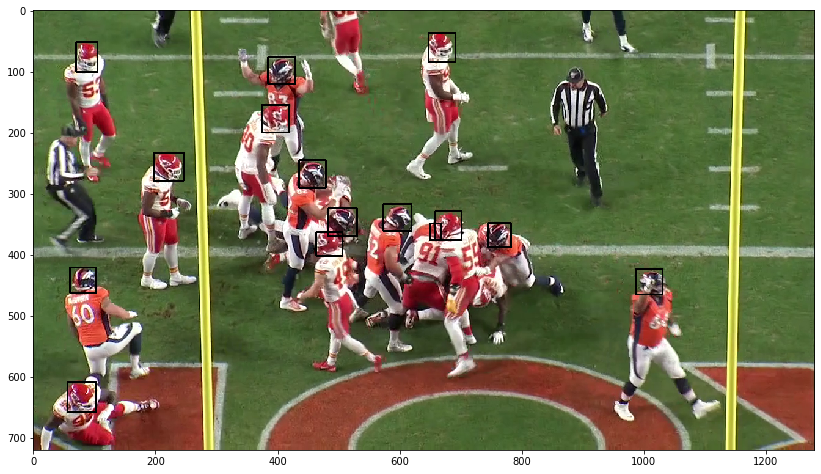

In [74]:
# Set the name of our working image
index_no = 0
img_df = train_df[train_df['x_train_id'] == index_no]
img_name = img_df['pic_id'].values[0]
img_path = 'data/coco/2020/annotations/train/' + img_name
frame_no = img_df['frame']

# Read in and plot the image
img = cv2.imread(img_path) 

#Set annotation color
HELMET_COLOR = (0, 0, 0)    # Black

# Plot all bounding boxes for matching pic_id and frame_no
boxes = y_train_df[y_train_df['pic_id'] == img_df['pic_id'].values[0]]
for j, box in boxes.iterrows():
    color = HELMET_COLOR
    # cv2.rectangle requires specification of the top left pixel and the bottom right pixel
    start_point = (int(box.left), int(box.top))
    end_point = (int(box.right), int(box.bottom))

    # Add a box around the helmet
    cv2.rectangle(img, start_point, end_point, color, thickness=2)

# Display the image with bounding boxes added
plt.figure(figsize=(14, 14))
plt.imshow(img)
plt.show()

# Write to JSON

This section involves writing annotations to JSON files similar to the COCO (Common Objects in Context) dataset format. These files do not match the COCO format exactly, but some features were kept just to mimic most of the COCO structure (i.e. license, coco_url, date_captured, and flickr_url were not used. Although not necessary, zero was imputed for "is_crowd"). More information on COCO is available here: https://cocodataset.org/#detection-2020. A breakdown of all files is below:

Images:
Image filenames and details of the image (height, width, id)

Categories:
One category: helmet

Objects:
Bounding box annotations

Annotations:
Combining all above JSON files as nested dictionaries

### Training Images

In [75]:
#Add train image files
images = []
for i, j in enumerate(train_df.image_id):
    images.append({"file_name": train_df.pic_id.values[i],
                   "height": X_train.shape[1],
                   "width": X_train.shape[2],
                   "x_train_id": int(train_df.x_train_id.values[i]),
                   "id": int(train_df.image_id.values[i])})

with open('images.json', 'w') as f:
    json.dump(images, f)
    
#Move to proper folder
shutil.move("images.json", "data/coco/2020/annotations/train/images.json")

'data/coco/2020/annotations/train/images.json'

In [76]:
#Preview train file
with open('data/coco/2020/annotations/train/images.json') as f:
    train_images = json.load(f)
    
#Preview train image file
train_images[0]

{'file_name': '57992301426.png',
 'height': 720,
 'width': 1280,
 'x_train_id': 0,
 'id': 57992301426}

### Test Images

In [77]:
#Add test image files
images = []
for i, j in enumerate(test_df.image_id):
    images.append({"file_name": test_df.pic_id.values[i],
                   "height": X_test.shape[1],
                   "width": X_test.shape[2],
                   "x_test_id": int(test_df.x_test_id.values[i]),
                   "id": int(test_df.image_id.values[i])})
with open('images.json', 'w') as f:
    json.dump(images, f)

#Move the file to the proper folder
shutil.move("images.json", "data/coco/2020/annotations/test/images.json")

'data/coco/2020/annotations/test/images.json'

In [78]:
#Preview test file
with open('data/coco/2020/annotations/test/images.json') as f:
    test_images = json.load(f)

#Preview test image file
test_images[0]

{'file_name': '577873413129.png',
 'height': 720,
 'width': 1280,
 'x_test_id': 0,
 'id': 577873413129}

### Train Categories

In [79]:
#Add train category file with 1 class, helmet
categories = []
categories.append({"id": 0, "name": "helmet"})
    
with open('categories.json', 'w') as f:
    json.dump(categories, f)
    
#Move to the proper folder
shutil.move("categories.json", "data/coco/2020/annotations/train/categories.json")

'data/coco/2020/annotations/train/categories.json'

In [80]:
#Preview train file
with open('data/coco/2020/annotations/train/categories.json') as f:
    train_categories = json.load(f)
    
#Preview train categories
train_categories

[{'id': 0, 'name': 'helmet'}]

### Test Categories

In [81]:
#Add test category file with 1 class, helmet
categories = []
categories.append({"id": 0, "name": "helmet"})

with open('categories.json', 'w') as f:
    json.dump(categories, f)
    
#Move to proper folder
shutil.move("categories.json", "data/coco/2020/annotations/test/categories.json")

'data/coco/2020/annotations/test/categories.json'

In [82]:
#Preview test file
with open('data/coco/2020/annotations/test/categories.json') as f:
    test_categories = json.load(f)

#Preview test categories
test_categories

[{'id': 0, 'name': 'helmet'}]

### Train Objects

The below section is bounding box annotations. The format for bounding boxes for this project is y1, x1, y2, x2 and bounding boxes are normalized by dividing x values by image width and y values by image height. All images are the same size, so the image width and height values used are 1280 and 720. The format for annotations is below:

id: The index of annotations
<br>
category_id: 0 since we are only detecting helmets
<br>
image_id: The image id (previously created in the train and test dataframes. needs to be unique)
<br>
objects: The count of objects in the image
<br>
bbox: The annotation list

In [83]:
#Normalize bounding boxes
y_train_df[['left_norm', 'right_norm']] = y_train_df[['left', 'right']] / X_train.shape[2]
y_train_df[['top_norm', 'bottom_norm']] = y_train_df[['top', 'bottom']] / X_train.shape[1]

In [84]:
#Convert to list to be added to JSON file format
annotation = y_train_df[['labels', 'top_norm', 'left_norm', 'bottom_norm', 'right_norm']].values
annotation = [list(i) for i in annotation]
type(annotation[0][0])

numpy.float64

In [85]:
#Add annotations to train objects file
objects = []

for i, j in enumerate(annotation):
    objects.append({"id": int(i), 
                    "category_id": int(0),
                    "iscrowd": int(0), 
                    "image_id": int(y_train_df.image_id.values[i]),
                    "objects": int(y_train_df.counts.values[i]), 
                    "bbox": j[1:]})
        
with open('objects.json', 'w') as f:
    json.dump(objects, f)
shutil.move("objects.json", "data/coco/2020/annotations/train/objects.json")

'data/coco/2020/annotations/train/objects.json'

In [86]:
#Preview train objects file
with open('data/coco/2020/annotations/train/objects.json') as f:
    train_annotations = json.load(f)
train_annotations[0]

{'id': 0,
 'category_id': 0,
 'iscrowd': 0,
 'image_id': 580942819185,
 'objects': 17,
 'bbox': [0.42083333333333334, 0.65, 0.4513888888888889, 0.66484375]}

### Test Objects

In [87]:
#Normalize bounding boxes
y_test_df[['left_norm', 'right_norm']] = y_test_df[['left', 'right']] / X_train.shape[2]
y_test_df[['top_norm', 'bottom_norm']] = y_test_df[['top', 'bottom']] / X_train.shape[1]

In [88]:
#Convert to list to be added to JSON file format
annotation = y_test_df[['labels', 'top_norm', 'left_norm', 'bottom_norm', 'right_norm']].values
annotation = [list(i) for i in annotation]

In [89]:
#Add annotations to test objects file
objects = []

for i, j in enumerate(annotation):
    objects.append({"id": int(i), 
                    "category_id": int(0), 
                    "iscrowd": int(0), 
                    "image_id": int(y_test_df.image_id.values[i]),
                    "objects": int(y_test_df.counts.values[i]),
                    "bbox": j[1:]})
        
with open('objects.json', 'w') as f:
    json.dump(objects, f)
shutil.move("objects.json", "data/coco/2020/annotations/test/objects.json")

'data/coco/2020/annotations/test/objects.json'

In [90]:
#Preview test objects file
with open('data/coco/2020/annotations/test/objects.json') as f:
    test_annotations = json.load(f)
test_annotations[0]

{'id': 0,
 'category_id': 0,
 'iscrowd': 0,
 'image_id': 57586540232,
 'objects': 16,
 'bbox': [0.44027777777777777, 0.47734375, 0.475, 0.4984375]}

### Train Annotations

Here we combine all files to one annotation file for training and one annotation file for testing.

In [91]:
#Combine files as dictionary and write to JSON
annotations = {"images": train_images, "annotations": train_annotations, "categories": train_categories}

with open('annotations.json', 'w') as f:
    json.dump(annotations, f)
shutil.move("annotations.json", "data/coco/2020/annotations/train/annotations.json")

'data/coco/2020/annotations/train/annotations.json'

In [92]:
#Preview train annotations
with open('data/coco/2020/annotations/train/annotations.json') as f:
    train_annotations = json.load(f)
print("Image sample:")
print(train_annotations['images'][0])
print("\n Annotations sample:")
print(train_annotations['annotations'][0])
print("\n Categories sample:")
print(train_annotations['categories'][0])

Image sample:
{'file_name': '57992301426.png', 'height': 720, 'width': 1280, 'x_train_id': 0, 'id': 57992301426}

 Annotations sample:
{'id': 0, 'category_id': 0, 'iscrowd': 0, 'image_id': 580942819185, 'objects': 17, 'bbox': [0.42083333333333334, 0.65, 0.4513888888888889, 0.66484375]}

 Categories sample:
{'id': 0, 'name': 'helmet'}


### Test Annotations

In [93]:
#Combine files as dictionary and write to JSON
annotations = {"images": test_images, "annotations": test_annotations, "categories": test_categories}

with open('annotations.json', 'w') as f:
    json.dump(annotations, f)
shutil.move("annotations.json", "data/coco/2020/annotations/test/annotations.json")

'data/coco/2020/annotations/test/annotations.json'

In [94]:
#Preview test annotations
with open('data/coco/2020/annotations/test/annotations.json') as f:
    test_annotations = json.load(f)
print("Image sample:")
print(test_annotations['images'][0])
print("\n Annotations sample:")
print(test_annotations['annotations'][0])
print("\n Categories sample:")
print(test_annotations['categories'][0])

Image sample:
{'file_name': '577873413129.png', 'height': 720, 'width': 1280, 'x_test_id': 0, 'id': 577873413129}

 Annotations sample:
{'id': 0, 'category_id': 0, 'iscrowd': 0, 'image_id': 57586540232, 'objects': 16, 'bbox': [0.44027777777777777, 0.47734375, 0.475, 0.4984375]}

 Categories sample:
{'id': 0, 'name': 'helmet'}


# Using the pycocotools API for Annotations

The [pycocotools API](https://github.com/cocodataset/cocoapi) is used to assist in parsing, loading, and visualizing annotations in the COCO format.

In [95]:
#Load train annotations file for parsing, loading, visualizing
train_annotations_file = 'data/coco/2020/annotations/train/annotations.json'

train_coco=COCO(train_annotations_file)

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


In [96]:
#Load test annotations file for parsing, loading, visualizing
test_annotations_file = 'data/coco/2020/annotations/test/annotations.json'

test_coco=COCO(test_annotations_file)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [97]:
#Preview total images
train_imgIds = train_coco.getImgIds()
print("Total images: {}".format(len(train_imgIds)))

#Select a random image
rand = np.random.randint(0,len(train_imgIds))
train_img = train_coco.loadImgs(train_imgIds[rand])[0]

#Preview example image
print("Image example:")
print(train_img)

#Preview total annotations
train_annIds = train_coco.getAnnIds()
print("\nTotal annotations: {}".format(len(train_annIds)))

#Preview example annotation
train_ann=train_coco.loadAnns(train_coco.getAnnIds(imgIds=train_img['id']))
print("Annotation example:")
print(train_ann[0])

Total images: 864
Image example:
{'file_name': '58000130653789.png', 'height': 720, 'width': 1280, 'x_train_id': 510, 'id': 58000130653789}

Total annotations: 17451
Annotation example:
{'id': 511, 'category_id': 0, 'iscrowd': 0, 'image_id': 58000130653789, 'objects': 22, 'bbox': [0.6597222222222222, 0.3609375, 0.6777777777777778, 0.3703125]}


In [98]:
#Testing set details
test_imgIds = test_coco.getImgIds()
print("Total images: {}".format(len(test_imgIds)))

#Select a random image
rand=np.random.randint(0,len(test_imgIds))
test_img = test_coco.loadImgs(test_imgIds[rand])[0]

#Preview example image
print("Image example:")
print(test_img)

#Preview total annotations
test_annIds=test_coco.getAnnIds()
print("\nTotal annotations: {}".format(len(test_annIds)))

#Preview example annotation
test_ann=test_coco.loadAnns(test_coco.getAnnIds(imgIds=test_img['id']))
print("Annotation example:")
print(test_ann[0])

Total images: 217
Image example:
{'file_name': '57992301338.png', 'height': 720, 'width': 1280, 'x_test_id': 109, 'id': 57992301338}

Total annotations: 4392
Annotation example:
{'id': 931, 'category_id': 0, 'iscrowd': 0, 'image_id': 57992301338, 'objects': 17, 'bbox': [0.3236111111111111, 0.709375, 0.3958333333333333, 0.73828125]}


In [99]:
#Preview train categories
cats = train_coco.loadCats(train_coco.getCatIds())
print("Number of categories: {}".format(len(cats)))

nms = [cat['name'] for cat in cats]
print('\nCOCO categories: \n{}\n'.format(' '.join(nms)))

Number of categories: 1

COCO categories: 
helmet



In [100]:
#Preview test categories
cats = test_coco.loadCats(test_coco.getCatIds())
print("Number of categories: {}".format(len(cats)))

nms = [cat['name'] for cat in cats]
print('\nCOCO categories: \n{}\n'.format(' '.join(nms)))

Number of categories: 1

COCO categories: 
helmet



# Create TFRecords (tensorflow)

Referencing this public Kaggle notebook, https://www.kaggle.com/karthikeyanvijayan/coco-object-detection-dataset-in-tfrecord, below we create a directory for train and test tensorflow records, specify the record path, and then convert files to tfrecords in order to properly utilize the keras implementation of RetinaNet for object detection.

A tensorflow dataset is an object type that is an easy-to-use and high-performance input pipeline for our model.

In [101]:
#Create tfrecord output directories
!mkdir 'data/coco/2020/train_tfrecords'
!mkdir 'data/coco/2020/test_tfrecords/'
train_records_path='data/coco/2020/train_tfrecords/'
test_records_path='data/coco/2020/test_tfrecords/'

mkdir: data/coco/2020/train_tfrecords: File exists
mkdir: data/coco/2020/test_tfrecords/: File exists


In [102]:
#Returns all the annotation data for a given image id
def get_annotations(coco, imgId):
    "Return all annotation data for a given tfrecord and image id using the pycocotools API."
    annIds=coco.getAnnIds(imgIds=imgId)
    anns=coco.loadAnns(annIds)
    bboxes=[]
    catIds=[]
    iscrowd_list=[]
    annotation_ids=[]
    for ann in anns:
        try:
            catId=ann['category_id']
            bbox=ann['bbox']
            iscrowd=ann['iscrowd']
            annotation_id=ann['id']
        except:
            continue
        if((not None in bbox) and (None!=catId)):
            catIds.append(catId)
            bboxes.append(bbox)
            iscrowd_list.append(iscrowd)
            annotation_ids.append(annotation_id)
    return len(anns),catIds,sum(bboxes,[]),iscrowd_list,annotation_ids

Here one tf record is written for training and one for testing.

In [104]:
img_dir = 'data/coco/2020/annotations/train/'
n=len(train_imgIds)
imgids=train_imgIds[0:n]
for i in imgids:
    img=train_coco.loadImgs(i)

#Only creating 1 file with filename of "0"
for i in range(0,1):
    examples=[]
    imgids=train_imgIds
    
    for img in tqdm.tqdm_notebook(train_coco.loadImgs(imgids)):
        image_string = cv2.imencode('.jpeg', X_train[img['x_train_id']])[1].tobytes()

        objects,catIds,bboxes,iscrowd,annotation_ids=get_annotations(coco=train_coco, imgId=img['id'])

        # Create a Features message using tf.train.Example.
        example = tf.train.Example(features=tf.train.Features(feature={
            'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_string])),
            'height': tf.train.Feature(int64_list=tf.train.Int64List(value=[img['height']])),
            'width': tf.train.Feature(int64_list=tf.train.Int64List(value=[img['width']])),
            'id': tf.train.Feature(int64_list=tf.train.Int64List(value=[img['id']])),
            'file_name': tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.compat.as_bytes(img['file_name'])])),
            #objects-Number of objects in the image
            'objects': tf.train.Feature(int64_list=tf.train.Int64List(value=[objects])),
            #Follwing features hold all the annotations data given for the image
            #category_ids-List of aannotation category ids
            'category_ids': tf.train.Feature(int64_list=tf.train.Int64List(value=catIds)),
            #bboxes flattened into 1D list
            'bboxes': tf.train.Feature(float_list=tf.train.FloatList(value=bboxes)),
            #List of iscrowd values
            'iscrowd': tf.train.Feature(int64_list=tf.train.Int64List(value=iscrowd)),
#             #List of area values
#             'area': tf.train.Feature(float_list=tf.train.FloatList(value=area)),
            #List of annotation ids 
            'annotation_ids': tf.train.Feature(int64_list=tf.train.Int64List(value=annotation_ids)),
        }))
        examples.append(example)
    
    with tf.io.TFRecordWriter(train_records_path+'coco'+str(i)+'.tfrecord') as writer:
        for j in examples:
            writer.write(j.SerializeToString())
    examples.clear()
    print("file {} created".format(i))


file 0 created


The below function parses tensorflow records into a dictionary and is a necessary step prior to training the model.

In [105]:
def parse(tfrecord):
    "Parse the features of a tensorflow record into a dictionary."
    
    features={
    'image': tf.io.FixedLenFeature([], tf.string),
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'id': tf.io.FixedLenFeature([], tf.int64),
    'file_name': tf.io.FixedLenFeature([], tf.string),
    'objects': tf.io.FixedLenFeature([], tf.int64),
    'category_ids': tf.io.VarLenFeature(tf.int64),
    'bboxes': tf.io.VarLenFeature(tf.float32),
    'iscrowd': tf.io.VarLenFeature(tf.int64),
    'annotation_ids': tf.io.VarLenFeature(tf.int64)
    }
    
    sample = tf.io.parse_example(tfrecord, features)
    image = tf.image.decode_png(sample['image'], channels=3)
    file_name = sample['file_name']
    objects = sample['objects']
    bboxes = sample['bboxes']
    bboxes = tf.sparse.to_dense(bboxes)
    bboxes = tf.reshape(bboxes, [objects, 4])
    annotation_ids = sample['annotation_ids']
    iscrowd = sample['iscrowd']
    iscrowd = tf.sparse.to_dense(iscrowd)
    category_ids = sample['category_ids']
    category_ids = tf.sparse.to_dense(category_ids)
    
    image_dict = {"image": image, 
                  "image/filename": file_name, 
                  "objects": {"bbox": bboxes, "id": annotation_ids, "iscrowd": iscrowd, "label": category_ids}
                 }
    
    return image_dict

In [106]:
#Load the tensorflow record as train_dataset
train_dataset = tf.data.TFRecordDataset(tf.io.gfile.glob(train_records_path+'*.tfrecord'))

In [107]:
#Parse the dataset
train_dataset = train_dataset.map(parse)

In [108]:
#Preview a row in the dataset
for i in train_dataset.take(1):
    print(i)

{'image': <tf.Tensor: shape=(720, 1280, 3), dtype=uint8, numpy=
array([[[ 42,  72,  20],
        [ 78, 108,  56],
        [ 81, 111,  59],
        ...,
        [ 79, 105,  58],
        [ 81, 107,  60],
        [ 37,  63,  16]],

       [[ 44,  74,  22],
        [ 81, 111,  59],
        [ 85, 115,  63],
        ...,
        [ 79, 105,  58],
        [ 82, 108,  61],
        [ 37,  63,  16]],

       [[ 41,  71,  19],
        [ 78, 108,  56],
        [ 84, 114,  60],
        ...,
        [ 81, 107,  60],
        [ 84, 110,  63],
        [ 39,  65,  18]],

       ...,

       [[ 66,  23,  16],
        [ 71,  28,  19],
        [ 90,  46,  37],
        ...,
        [137,  81,  58],
        [123,  67,  44],
        [ 88,  34,  10]],

       [[ 66,  23,  16],
        [ 71,  28,  19],
        [ 91,  47,  38],
        ...,
        [137,  81,  56],
        [122,  66,  43],
        [ 87,  33,   9]],

       [[ 66,  23,  16],
        [ 71,  28,  19],
        [ 92,  48,  39],
        ...,
        [1

Repeating the same process for the test dataset below.

In [109]:
#Size of each TFRecord file will be 100MB for improving performance
img_dir = 'data/coco/2020/annotations/test/'
n=len(test_imgIds)
imgids=test_imgIds[0:n]
size=0
for i in imgids:
    img=test_coco.loadImgs(i)
#     fn=img[0]['file_name']
#     size+=os.path.getsize(img_dir+fn)
# avg_size=size/n
# limit=int(104857600//avg_size)
# total_tfrecords=int(len(test_imgIds)//limit)
# print("{} TFRecord files will be created".format(total_tfrecords))

# for i in range(0,total_tfrecords):
for i in range(1, 2):
#     examples=[]
#     start=i*limit
#     end=start+limit
#     imgids=test_imgIds[start:end]
    imgids=test_imgIds
    
    for img in tqdm.tqdm_notebook(test_coco.loadImgs(imgids)):
        image_string = cv2.imencode('.jpeg', X_test[img['x_test_id']])[1].tobytes()

        objects,catIds,bboxes,iscrowd,annotation_ids=get_annotations(coco=test_coco, imgId=img['id'])

        # Create a Features message using tf.train.Example.
        example = tf.train.Example(features=tf.train.Features(feature={
            'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_string])),
            'height': tf.train.Feature(int64_list=tf.train.Int64List(value=[img['height']])),
            'width': tf.train.Feature(int64_list=tf.train.Int64List(value=[img['width']])),
            'id': tf.train.Feature(int64_list=tf.train.Int64List(value=[img['id']])),
            'file_name': tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.compat.as_bytes(img['file_name'])])),
            #objects-Number of objects in the image
            'objects': tf.train.Feature(int64_list=tf.train.Int64List(value=[objects])),
            #Follwing features hold all the annotations data given for the image
            #category_ids-List of aannotation category ids
            'category_ids': tf.train.Feature(int64_list=tf.train.Int64List(value=catIds)),
            #bboxes flattened into 1D list
            'bboxes': tf.train.Feature(float_list=tf.train.FloatList(value=bboxes)),
            #List of iscrowd values
            'iscrowd': tf.train.Feature(int64_list=tf.train.Int64List(value=iscrowd)),
            #List of annotation ids 
            'annotation_ids': tf.train.Feature(int64_list=tf.train.Int64List(value=annotation_ids)),
        }))
        examples.append(example)
    
    with tf.io.TFRecordWriter(test_records_path+'coco'+str(i)+'.tfrecord') as writer:
        for j in examples:
            writer.write(j.SerializeToString())
    examples.clear()
    print("file {} created".format(i))


file 1 created


In [110]:
#Load the tensorflow record as test_dataset
test_dataset = tf.data.TFRecordDataset(tf.io.gfile.glob(test_records_path+'*.tfrecord'))

In [111]:
#Parse the test_dataset
test_dataset = test_dataset.map(parse)

In [112]:
#Preview the dataset
for i in test_dataset.take(1):
    print(i)

{'image': <tf.Tensor: shape=(720, 1280, 3), dtype=uint8, numpy=
array([[[ 37,  60,   8],
        [ 86, 109,  57],
        [ 85, 108,  54],
        ...,
        [ 78,  79,  61],
        [ 62,  63,  45],
        [ 40,  41,  23]],

       [[ 37,  60,   8],
        [ 82, 105,  53],
        [ 84, 107,  53],
        ...,
        [ 79,  80,  62],
        [ 64,  65,  47],
        [ 44,  45,  27]],

       [[ 44,  67,  15],
        [ 83, 106,  54],
        [ 83, 106,  52],
        ...,
        [ 75,  78,  57],
        [ 60,  63,  42],
        [ 40,  43,  22]],

       ...,

       [[ 35,  48,  18],
        [ 80,  96,  59],
        [ 81,  99,  49],
        ...,
        [ 78, 110,  45],
        [ 71, 102,  43],
        [ 38,  69,  12]],

       [[ 34,  49,  18],
        [ 79,  95,  58],
        [ 80,  98,  48],
        ...,
        [ 76, 108,  43],
        [ 67,  98,  39],
        [ 35,  66,   9]],

       [[ 38,  53,  22],
        [ 82,  98,  61],
        [ 80, 100,  49],
        ...,
        [ 

# Write y_test_df to CSV file

In [685]:
y_test_df.to_csv('y_test_df.csv')

# Write Test Videos to TensorFlow Records

Converting the test video arrays to tfrecords makes it easier to upload to Google Cloud and convert back to an array for predictions.

In [1006]:
# Define the path and then display the video using 
endzone_vid_path = "test_vid/57583_000082_Endzone.mp4"
sideline_vid_path = "test_vid/57583_000082_Sideline.mp4"

In [1007]:
def frames_to_arrays(vid_path):
    
    """Capture frames from video as list of image arrays.
    Arguments: 
      vid_path: Video path to capture frames.
    Returns: Each frame of the specified video as an array."""
    
    test_video_list = []
    test_missing_list = []
    date_time = []
    cap = cv2.VideoCapture(vid_path)
    frames_in_video = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    for i in tqdm.tqdm_notebook(range(0, frames_in_video)):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        date_time.append(datetime.datetime.now())
        success, img_array = cap.read()
        if success == True:
            test_video_list.append(img_array)
        else:
            test_missing_list.append(i)
    final_video_array = np.array(test_video_list)
    frames_to_arrays.final_video_array = final_video_array
    frames_to_arrays.date_time = date_time

In [1008]:
frames_to_arrays(endzone_vid_path)

In [189]:
#Convert list to array
endzone_video_array = frames_to_arrays.final_video_array

In [190]:
#Preview shape
endzone_video_array.shape

(472, 720, 1280, 3)

In [191]:
frames_to_arrays(sideline_vid_path)

In [192]:
#Convert list to array
sideline_video_array = frames_to_arrays.final_video_array

In [193]:
#Preview shape
sideline_video_array.shape

(471, 720, 1280, 3)

In [194]:
examples = []
for ind, img in tqdm.tqdm_notebook(enumerate(endzone_video_array)):
    img_string = cv2.imencode('.jpeg', img)[1].tobytes()
    
    # Create a Features message using tf.train.Example.
    example = tf.train.Example(features=tf.train.Features(feature={
        'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_string]))}))
    
    examples.append(example)
    
with tf.io.TFRecordWriter('test_vid/endzone.tfrecord') as writer:
    for j in examples:
        writer.write(j.SerializeToString())
    examples.clear()

In [195]:
examples = []
for ind, img in tqdm.tqdm_notebook(enumerate(sideline_video_array)):
    img_string = cv2.imencode('.jpeg', img)[1].tobytes()
    
    # Create a Features message using tf.train.Example.
    example = tf.train.Example(features=tf.train.Features(feature={
        'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_string]))}))
    
    examples.append(example)
    
with tf.io.TFRecordWriter('test_vid/sideline.tfrecord') as writer:
    for j in examples:
        writer.write(j.SerializeToString())
    examples.clear()